# Explore lexicon in Vatican publications

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import pymongo

In [3]:
db = pymongo.MongoClient()['vatican']['tokens']

In [4]:
def documents():
    q = {'$group': {'_id': {'pope': '$pope', 'document': '$document'}}}
    docs = []
    for record in db.aggregate([q]):
        docs.append((record['_id']['pope'], record['_id']['document']))
    return docs

In [5]:
docs = documents()

In [6]:
len(docs)

196

In [95]:
[(x, y) for x, y in docs if x == 'Leo XIII']

[('Leo XIII', 'Litteras A Vobis'),
 ('Leo XIII', 'Iucunda Semper Expectatione'),
 ('Leo XIII', 'Pastoralis Officii'),
 ('Leo XIII', 'Supremi Apostolatus Officio'),
 ('Leo XIII', 'Etsi Nos'),
 ('Leo XIII', 'Quod Apostolici Muneris'),
 ('Leo XIII', 'In Plurimis'),
 ('Leo XIII', 'Licet Multa'),
 ('Leo XIII', 'Paterna Caritas'),
 ('Leo XIII', 'Spectata Fides'),
 ('Leo XIII', 'Affari Vos'),
 ('Leo XIII', 'Cum Multa'),
 ('Leo XIII', 'Inimica Vis'),
 ('Leo XIII', 'Libertas'),
 ('Leo XIII', 'In Ipso'),
 ('Leo XIII', 'Grande Munus'),
 ('Leo XIII', 'Pastoralis'),
 ('Leo XIII', 'Sancta Dei Civitas'),
 ('Leo XIII', 'Longinqua'),
 ('Leo XIII', 'Magni Nobis'),
 ('Leo XIII', 'Pergrata'),
 ('Leo XIII', 'Quamquam Pluries'),
 ('Leo XIII', 'Iampridem'),
 ('Leo XIII', 'Custodi Di Quella Fede'),
 ('Leo XIII', 'Quod Auctoritate'),
 ('Leo XIII', 'Exeunte Iam Anno'),
 ('Leo XIII', 'Caritatis'),
 ('Leo XIII', 'Arcanum'),
 ('Leo XIII', 'Constanti Hungarorum'),
 ('Leo XIII', 'Inter Graves'),
 ('Leo XIII', 'Mirae

## Term Frequency (TF)

$$
tf(d, t) = \frac{count(d, t)}{\max\limits_{i}^{n} count(d, t_i)}
$$

In [9]:
def document_term_count(pope, document, field='lemma'):
    m = {'$match': {'pope': pope, 'document': document}}
    g = {'$group': {'_id': "${}".format(field), 'count': {'$sum': 1}}}
    data = {}
    for record in db.aggregate([m, g]):
        data[record['_id']] = record['count']
    return pd.Series(data)

In [71]:
pope, document = 'Paul VI', 'Humanae Vitae'
tf_count = document_term_count(pope, document)
tf = tf_count / tf_count.max()

In [72]:
tf_count.sort_values(ascending=False).head(10)

,         444
il        406
di il     290
e         220
di        199
.         193
a il      135
essere    127
che       116
uno        80
dtype: int64

In [73]:
tf.sort_values(ascending=False).head(10)

,         1.000000
il        0.914414
di il     0.653153
e         0.495495
di        0.448198
.         0.434685
a il      0.304054
essere    0.286036
che       0.261261
uno       0.180180
dtype: float64

## Document Frequency and Inverse Document Frequency (IDF)

$$
df(t) = \mid\{ d_i : t \in d_i \}\mid
$$

$$
idf(t) = \log \frac{N}{df(t)}
$$

In [74]:
def sentence_df(field='lemma'):
    g = {'$group': {'_id': {'token': "${}".format(field), 'document': "$document", 'sentence': "$sentence"}}}
    g2 = {'$group': {'_id': '$_id.token', 'count': {'$sum': 1}}}
    data = {}
    for record in db.aggregate([g, g2], allowDiskUse=True):
        data[record['_id']] = record['count']
    return pd.Series(data)

def sentence_count():
    g = {'$group': {'_id': {'document': "$document", 'sentence': "$sentence"}}}
    return len([x for x in db.aggregate([g])])

In [75]:
df = sentence_df()
s_count = sentence_count()

In [76]:
s_count

69512

In [77]:
df.sort_values(ascending=False).head(10)

.         50205
,         45529
il        41112
e         31473
di il     29058
di        27873
essere    23354
che       22799
a il      16575
a         15565
dtype: int64

In [85]:
idf = np.log(s_count / df)

In [86]:
idf.sort_values(ascending=False).head(10)

quell'«apparizione    11.149255
flessibilità          11.149255
anelino               11.149255
moltiplicassero       11.149255
indeterminare         11.149255
mangrovie             11.149255
liberati»187          11.149255
mediterraneo          11.149255
universale.(Is        11.149255
inasprimento          11.149255
dtype: float64

## TfIdf

$$
tfidf(d, t) = tf(d, t) \cdot idf(t)
$$

In [87]:
def tfidf(tf, idf, min_idf=0):
    tfidf_data = {}
    for t, tf_x in tf.items():
        idf_w = idf[t]
        if idf_w >= min_idf:
            tfidf_data[t] = tf_x * idf_w 
    return pd.Series(tfidf_data)

In [88]:
tfidf_hv = tfidf(tf, idf, min_idf=4)

In [89]:
tfidf_hv.sort_values(ascending=False).head(10)

coniugale      0.473365
sposo          0.361592
coniuge        0.242326
matrimonio     0.229734
atto           0.219487
regolazione    0.207530
morale         0.198530
naturale       0.173230
natalità       0.168568
paternità      0.165374
dtype: float64

In [91]:
tfidf_hv['matrimonio'], tfidf_hv['lavoro']

(0.22973358579235933, 0.019501073485787893)

In [92]:
import matplotlib.pyplot as plt

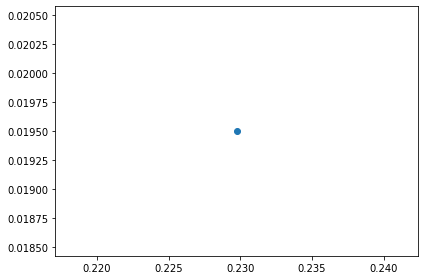

In [93]:
fig, ax = plt.subplots()
ax.scatter([tfidf_hv['matrimonio']], [tfidf_hv['lavoro']])
plt.tight_layout()
plt.show()

In [97]:
def doc_tfidf(pope, document):
    tf_count = document_term_count(pope, document)
    tf = tf_count / tf_count.max()
    tfidf_x = tfidf(tf, idf, min_idf=4)
    return tfidf_x

In [99]:
from collections import defaultdict

In [112]:
d1 = ('Paul VI', 'Humanae Vitae')
d2 = ('Leo XIII', 'Rerum Novarum')
d3 = ('Leo XIII', 'Caritatis')
cases = [d1, d2, d3]
index_docs = defaultdict(lambda: defaultdict(lambda: 0))
for pope, doc in cases:
    data_case = doc_tfidf(pope, doc)
    for word, tfidf_w in data_case.items():
        index_docs["{} {}".format(pope, doc)][word] = tfidf_w

In [113]:
dfr = pd.DataFrame(index_docs).fillna(0)

In [114]:
dfr.sort_values('Leo XIII Rerum Novarum', ascending=False)

,Paul VI Humanae Vitae,Leo XIII Rerum Novarum,Leo XIII Caritatis
operaio,0.000000,0.344368,0.027143
stato,0.019365,0.236363,0.139373
lavoro,0.019501,0.184127,0.043184
società,0.036108,0.166307,0.059970
proprietà,0.000000,0.156526,0.000000
...,...,...,...
recente,0.040631,0.000000,0.000000
promulgare,0.016392,0.000000,0.000000
addirittura,0.014808,0.000000,0.000000
direttiva,0.015542,0.000000,0.017209


In [115]:
dfr.loc[['matrimonio', 'lavoro']].T

,matrimonio,lavoro
Paul VI Humanae Vitae,0.229734,0.019501
Leo XIII Rerum Novarum,0.005569,0.184127
Leo XIII Caritatis,0.013388,0.043184


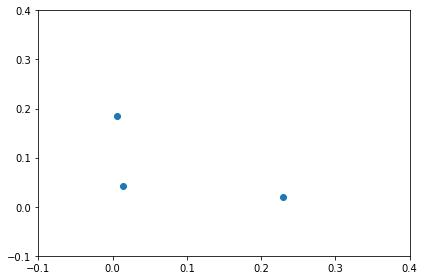

In [118]:
fig, ax = plt.subplots()
ax.scatter(dfr.T['matrimonio'], dfr.T['lavoro'])
ax.set_ylim(-.1, .4)
ax.set_xlim(-.1, .4)
plt.tight_layout()
plt.show()

## Euclidean similarity

In [124]:
v1 = dfr['Paul VI Humanae Vitae'].values
v2 = dfr['Leo XIII Rerum Novarum'].values
v3 = dfr['Leo XIII Caritatis'].values

In [132]:
np.linalg.norm(v2 - v3)

1.3030388519631342

## Kullback–Leibler divergence

$$
KL(x) = P(x) \log\left(\frac{P(x)}{Q(x)}\right)
$$